In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup # Webscraping
import requests # HTTP requests
import time # spacing time between requests to avoid rate limiting
from sklearn.ensemble import GradientBoostingRegressor # Regression


from sklearn.model_selection import train_test_split # data division
from sklearn.metrics import mean_squared_error, r2_score # model metrics
from sklearn import preprocessing # normalization
import scipy.stats as st
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
from scipy.stats import norm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Collection

In [2]:
# Setting constants for webscraping URLs
BOX_SCORES_URL ='https://www.pro-football-reference.com/super-bowl/'
BASE_URL = 'https://www.pro-football-reference.com'

# Constructing initial dataframe
df = pd.DataFrame()
# Sending request to page containing links to each Super Bowl
box_scores_html = requests.get(BOX_SCORES_URL)
time.sleep(3)
# Initializing Super Bowl soup object
box_scores_soup = BeautifulSoup(box_scores_html.content)
#Finding cells containing links to each Super Bowl
all_super_bowl_cells = box_scores_soup.find_all('td', attrs={'data-stat': 'superbowl'})
game_num = 0
def get_team_info(team_url):
    # Get the HTML for the team's page
    team_html = requests.get(team_url)
    time.sleep(3)
    # Parse the table on the page for information on the team and their opponents
    team_soup = BeautifulSoup(team_html.content)
    team_table = team_soup.find('table')
    team_table_headers = team_table.find('thead').find_all('tr')[1].find_all('th')
    team_column_names = ['team_' + x.get('data-stat') for x in team_table_headers[1:]]
    opp_column_names = ['season_opp_' + x.get('data-stat') for x in team_table_headers[1:]]
    column_names = team_column_names + opp_column_names
    team_table_row = team_table.find_all('tr')[2]
    team_stats = team_table_row.find_all('td')
    team_stats = [x.decode_contents() for x in team_stats]
    opp_table_row = team_table.find_all('tr')[3]
    opp_stats = opp_table_row.find_all('td')
    opp_stats = [x.decode_contents() for x in opp_stats]
    # Store the data in a dataframe to be returned 
    stats = team_stats + opp_stats
    team_df = pd.DataFrame(columns = column_names)
    team_df.loc[0] = stats
    return team_df
    
def parse_game(game_url):
    global df
    # Get the HTML for a game's page
    game_html = requests.get(game_url)
    time.sleep(3)
    # Parse the data for both teams playing in that game, and get their info. 
    game_soup = BeautifulSoup(game_html.content)
    super_bowl_name = game_soup.find('title').decode_contents().split("-")[0]
    scorebox = game_soup.find('div', attrs={'class': 'scorebox'})
    scorebox_links = scorebox.find_all('a')
    team_links = [link.get('href') for link in scorebox_links if '/teams/' in link.get('href')]
    team_1_info = get_team_info(BASE_URL + team_links[0])
    team_2_info = get_team_info(BASE_URL + team_links[1])
    
    #Combine each team's information with their Super Bowl opponent's in a singular row
    team_1_combined_info = pd.concat([team_1_info, team_2_info], axis=1)
    team_1_combined_info.columns = team_1_combined_info.columns[:60].to_list() + ["sb_opp_" + col_name for col_name in team_1_combined_info.columns[60:]]
    
    team_2_combined_info = pd.concat([team_2_info, team_1_info], axis=1)
    team_2_combined_info.columns = team_2_combined_info.columns[:60].to_list() + ["sb_opp_" + col_name for col_name in team_2_combined_info.columns[60:]]
    
    # Collect the total points scored at the each quarter for each team
    score_rows = game_soup.find_all('tr')
    team_1_scores = [int(score.decode_contents()) for score in score_rows[1].find_all('td')[-5:-1]]
    team_2_scores = [int(score.decode_contents()) for score in score_rows[2].find_all('td')[-5:-1]]
    team_1_sum_scores = []
    team_2_sum_scores = []
    for i in range(1,5):
        team_1_sum_scores.append(sum(team_1_scores[:i + 1]))
        team_2_sum_scores.append(sum(team_2_scores[:i + 1]))
    if(len(df.columns) == 0):
        df = pd.DataFrame(columns = ["game", "quarter"] + team_1_combined_info.columns.to_list())
    temp_df = pd.DataFrame([[super_bowl_name, i] for i in range(1,5)], columns=["game", "quarter"])
    # Create a dataframe containing 4 duplicate rows of the stats for each team
    quadrupled_team_1_combined_info = pd.concat([team_1_combined_info, team_1_combined_info, team_1_combined_info, team_1_combined_info], axis=0)
    quadrupled_team_2_combined_info = pd.concat([team_2_combined_info, team_2_combined_info, team_2_combined_info, team_2_combined_info], axis=0)
    quadrupled_team_1_combined_info.reset_index(inplace=True)
    quadrupled_team_2_combined_info.reset_index(inplace=True)
    # Add the scores for each quarter to the dataframes containing 4 duplicate rows
    team_1_temp_df = temp_df.copy()
    team_1_temp_df.insert(2, "score", team_1_sum_scores, True)
    team_1_complete = pd.concat([team_1_temp_df, quadrupled_team_1_combined_info], axis=1)
    team_2_temp_df = temp_df.copy()
    team_2_temp_df.insert(2, "score", team_2_sum_scores, True)
    team_2_complete = pd.concat([team_2_temp_df, quadrupled_team_2_combined_info], axis=1)
    # Add both teams to the dataframe containing the records of each quarter of each game
    df = pd.concat([df, team_1_complete], axis=0)
    df = pd.concat([df, team_2_complete], axis=0)

# Collect data for each of the past 24 Super Bowls, as the format of the data beyond that is stored differently
for cell in all_super_bowl_cells[:24]:
    print("Parsing Game", game_num)
    game_url = cell.find('a').get('href')
    parse_game(BASE_URL + game_url)
    game_num += 1

Parsing Game 0
Parsing Game 1
Parsing Game 2
Parsing Game 3
Parsing Game 4
Parsing Game 5
Parsing Game 6
Parsing Game 7
Parsing Game 8
Parsing Game 9
Parsing Game 10
Parsing Game 11
Parsing Game 12
Parsing Game 13
Parsing Game 14
Parsing Game 15
Parsing Game 16
Parsing Game 17
Parsing Game 18
Parsing Game 19
Parsing Game 20
Parsing Game 21
Parsing Game 22
Parsing Game 23


# Data Preprocessing

In [3]:
# Helper function to convert roman numerals to integers
def roman_to_int(s):
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    i = 0
    num = 0
    while i < len(s):
        if i+1<len(s) and s[i:i+2] in roman:
            num+=roman[s[i:i+2]]
            i+=2
        elif s[i] in roman:
            #print(i)
            num+=roman[s[i]]
            i+=1
        else:
            return s
        
    return num

# Convert all game numbers from roman numerals to integers
df['game'] = [roman_to_int(game.split()[-1]) for game in df['game']]

In [4]:
# Helper function to convert non-numeric columns to a numeric format
def fix_nonnumeric_columns(target):
    for team in ['team', 'season_opp', 'sb_opp_team', 'sb_opp_season_opp']:
        target[team + '_start_avg'] = [start.split(" ")[1] for start in target[team + '_start_avg']]
        target[team + '_time_avg'] = [int(time.split(":")[0]) + int(time.split(":")[1]) / 60 for time in target[team + '_time_avg']]
    return target

df = fix_nonnumeric_columns(df)

In [5]:
# Normalize each numeric column (minus game number and quarter)
columns = df.columns
x = df.iloc[:, 2:122].values
scaler = preprocessing.MinMaxScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)
df.iloc[:, 2:122] = x_scaled
df.columns = columns
df = df.iloc[:, :123]

In [6]:
# Store each feature's correlation with score inside a tuple along with that feature's name
annotated_score_correlations = []
score_correlations = df.corr()['score']
for column in df.columns:
    annotated_score_correlations.append((column, score_correlations[column]))
    
# Sort each feature correlation tuple by descending order of correlation to the 'score' feature
sorted_annotated_score_correlations = sorted(annotated_score_correlations, key=lambda annotation: abs(annotation[1]), reverse=True)[1:]

# Model Evaluation

In [7]:
# Set the target variable to 'score'
df = df.astype('float')
y = df['score']

from itertools import compress, product

def combinations(items):
      return ( list(set(compress(items,mask))) for mask in product(*[[0,1]]*len(items)) )

# Find the best combination of features with the strongest correlation that produces the most accurate model
potential_columns = [column[0] for column in sorted_annotated_score_correlations[:15]]
column_combinations = list(combinations(np.arange(start=0, stop=10)))[1:]
def find_best_model_parameters():
    top_r2_score = 0
    best_model = None
    best_model_residuals = None
    best_columns_of_interest = []
    for combination in column_combinations:
        columns_of_interest = [sorted_annotated_score_correlations[num][0] for num in combination]
        X = df[columns_of_interest]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
        reg = GradientBoostingRegressor().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        residuals = y_test - y_pred
        r2 = r2_score(y_test, y_pred)
        # If this model is found to be the best so far, store the relevant metrics, along with the model itself
        if r2 > top_r2_score:
            best_model = reg
            top_r2_score = r2
            best_model_residuals = residuals
            best_columns_of_interest = columns_of_interest
    return best_model, best_model_residuals, top_r2_score, best_columns_of_interest
        
        

    
reg, residuals, r2, columns_of_interest = find_best_model_parameters()
r2

0.804118257949774

# Prediction Data Collection

In [8]:
# Retreive information of the two teams playing in the target game and create dataframes in the same format as the training data
AFC_link = 'https://www.pro-football-reference.com/teams/kan/2023.htm'
NFC_link = 'https://www.pro-football-reference.com/teams/sfo/2023.htm'
AFC_info = get_team_info(AFC_link)
NFC_info = get_team_info(NFC_link)

AFC_combined_info = pd.concat([AFC_info, NFC_info], axis=1)
AFC_combined_info.columns = AFC_combined_info.columns[:60].to_list() + ["sb_opp_" + col_name for col_name in AFC_combined_info.columns[60:]]
    
NFC_combined_info = pd.concat([NFC_info, AFC_info], axis=1)
NFC_combined_info.columns = NFC_combined_info.columns[:60].to_list() + ["sb_opp_" + col_name for col_name in NFC_combined_info.columns[60:]]

AFC_df = pd.concat([AFC_combined_info, AFC_combined_info, AFC_combined_info, AFC_combined_info], axis=0)
NFC_df = pd.concat([NFC_combined_info, NFC_combined_info, NFC_combined_info, NFC_combined_info], axis=0)
quarters = [1, 2, 3, 4]
game = [58, 58, 58, 58]
AFC_df.insert(0, "game", game, True)
AFC_df.insert(1, "quarter", quarters, True)
NFC_df.insert(0, "game", game, True)
NFC_df.insert(1, "quarter", quarters, True)
AFC_df.reset_index(inplace=True)
NFC_df.reset_index(inplace=True)


NFC_df = fix_nonnumeric_columns(NFC_df.iloc[:, 1:123]).astype('float')
AFC_df = fix_nonnumeric_columns(AFC_df.iloc[:, 1:123]).astype('float')

In [9]:
# Scale each dataframe using the same minmax scaler used on the training data
columns = AFC_df.columns
AFC_scaled = scaler.transform(AFC_df.iloc[:, 2:123])
AFC_df.iloc[:, 2:122] = AFC_scaled
AFC_df.columns = columns
NFC_scaled = scaler.transform(NFC_df.iloc[:, 2:123])
NFC_df.iloc[:, 2:122] = NFC_scaled
NFC_df.columns = columns

#Minimize the dataset to only include the columns found to be most useful within the training data
AFC_df = AFC_df[columns_of_interest]
NFC_df = NFC_df[columns_of_interest]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


# Prediction

## Quarter by Quarter

In [10]:
# Make predictions for each quarter
AFC_pred = reg.predict(AFC_df)
NFC_pred = reg.predict(NFC_df)

for i in range(4):
    print("Q" + str(i + 1) +" Score: 49ers", round(NFC_pred[i]), "Chiefs", round(AFC_pred[i]))

Q1 Score: 49ers 21 Chiefs 13
Q2 Score: 49ers 31 Chiefs 14
Q3 Score: 49ers 35 Chiefs 18
Q4 Score: 49ers 35 Chiefs 18


## Final Score


In [11]:
# Calculate distribution parameters for the residuals
res_mean = sum(residuals) / len(residuals) 
res_var = sum([((res - res_mean) ** 2) for res in residuals]) / len(residuals) 
res_std = res_var ** 0.5

print("49ers Final Score:", round(NFC_pred[3]), '+/-', res_mean)
print("Chiefs Final Score:", round(AFC_pred[3]), '+/-', res_mean)

49ers Final Score: 35 +/- 0.09808481560228016
Chiefs Final Score: 18 +/- 0.09808481560228016


## Squares Likelihood

In [12]:
# Helper function to calculate the residual for a certain datapoint
def calculate_residual(predicted, value):
    return value - predicted
# Helper function to calculate the probability using z-score
def calculate_probability(max, min, mean, std):
    max_z = (max - mean) / std
    min_z = (min - mean) / std
    return norm.cdf(max_z) - norm.cdf(min_z)


# Initialize the arrays for each conference's probabilities
AFC_probabilities = [[], [], [], []]
NFC_probabilities = [[], [], [], []]

for i in range(4):
    for j in range(10):
        AFC_probabilities[i].append(0)
        NFC_probabilities[i].append(0)

        
# Calculate the probability of each score up to 100 occuring, and then store it in the appropriate bin according to it's last digit
# Only the last digit will be considered due to the nature of the Super Bowl Square game
for i in range(0, 4):
    for j in range(100):
        min = j - .5
        if j == 0:
            min = 0
        max = j + .5
        # Calculate the residual for each boundary of a given score
        # Example, the point of 16 would range between 15.5 and 16.5
        AFC_min_residual = calculate_residual(AFC_pred[i], min)
        AFC_max_residual = calculate_residual(AFC_pred[i], max)
        # Calculate the probability of a value within that range occuring, and store it within the appropriate bin for that score
        AFC_probability = calculate_probability(AFC_max_residual, AFC_min_residual, res_mean, res_std)
        AFC_probabilities[i][j % 10] += AFC_probability
        # Repeat the above process for the NFC
        NFC_min_residual = calculate_residual(NFC_pred[i], min)
        NFC_max_residual = calculate_residual(NFC_pred[i], max)
        NFC_probability = calculate_probability(NFC_max_residual, NFC_min_residual, res_mean, res_std)
        NFC_probabilities[i][j % 10] += NFC_probability
    
    

In [13]:
# Calculate the cross-probabilities for each score combination occuring, and scale it relative to every other possible scoring combination
cross_probabilities = []
for i in range(4):
    cross_probabilities.append([])
    qtr_sum = 0
    for a in range(10):
        cross_probabilities[i].append([])
        for n in range(10):
            cross_probability = AFC_probabilities[i][a] * NFC_probabilities[i][n]
            qtr_sum += cross_probability
            cross_probabilities[i][a].append(cross_probability)
    for a in range(10):
        cross_probabilities[i][a] = cross_probabilities[i][a] / qtr_sum
        

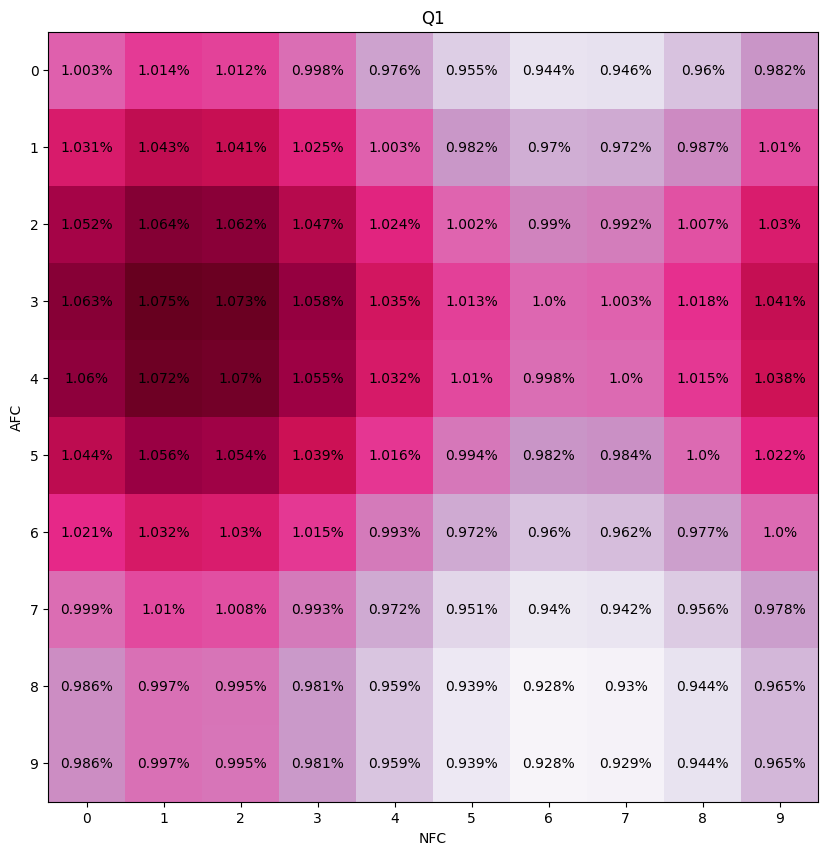

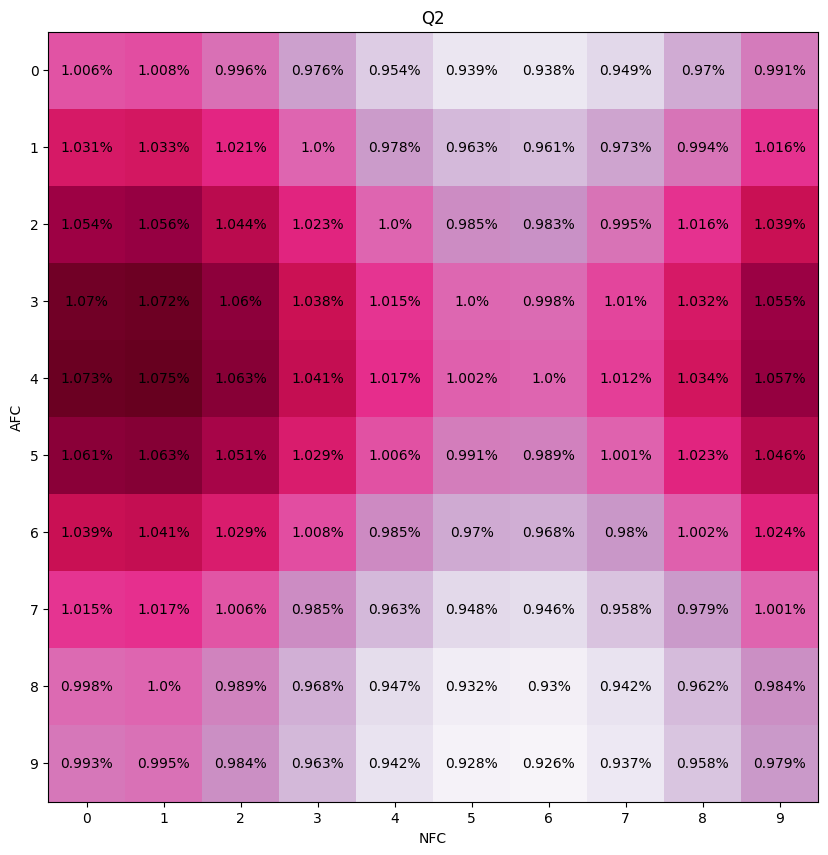

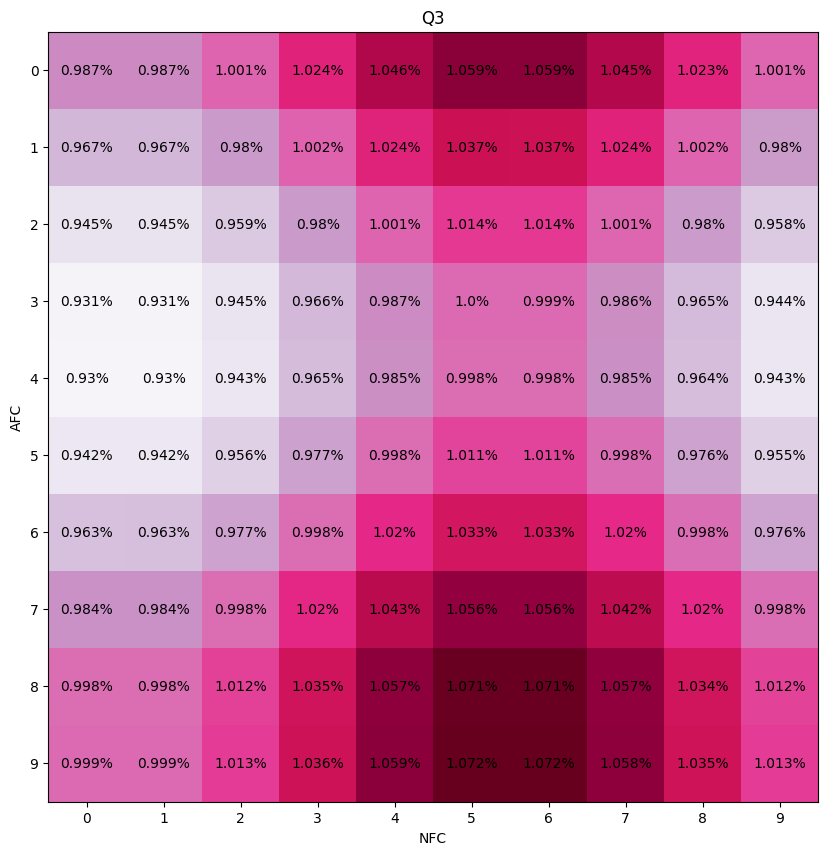

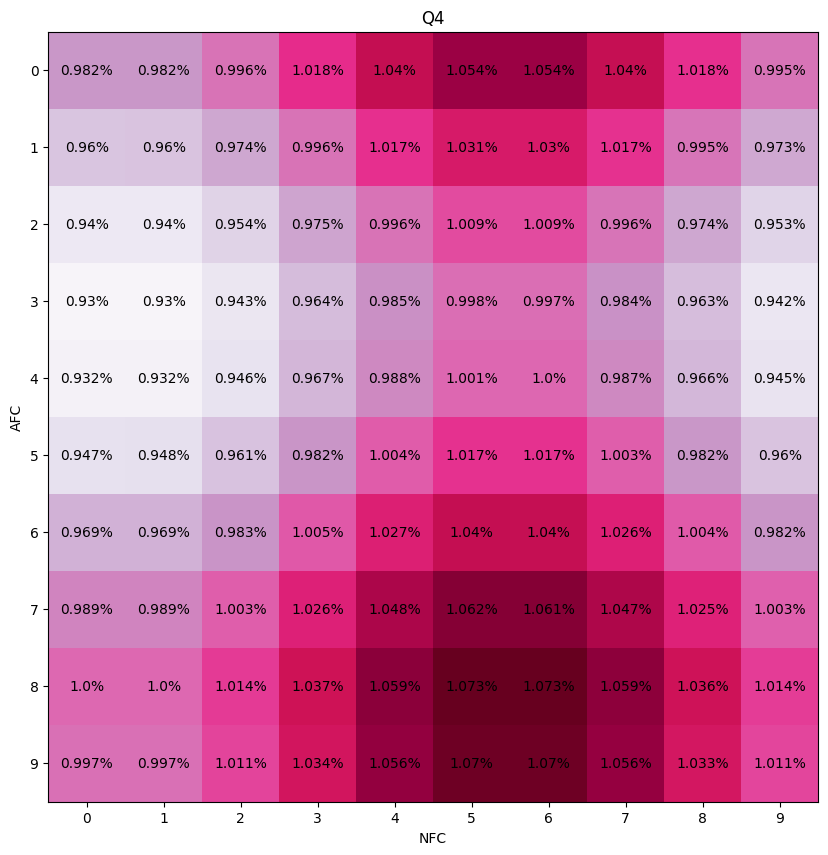

In [14]:
# Plot a 2d heatmap of the likelihood of each square occuring for each quarter of the game
plt.figure(figsize=(10, 10));
plt.xlabel('NFC')
plt.ylabel('AFC')
plt.xticks(range(10))
plt.yticks(range(10))
plt.title("Q1")
plt.imshow(cross_probabilities[0], cmap='PuRd');
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(cross_probabilities[0][i][j] * 100, 3)) + '%', xy=(j, i),
                     ha='center', va='center', color='Black')
        
plt.figure(figsize=(10, 10));
plt.xlabel('NFC')
plt.ylabel('AFC')
plt.xticks(range(10))
plt.yticks(range(10))
plt.title("Q2")
plt.imshow(cross_probabilities[1], cmap='PuRd');
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(cross_probabilities[1][i][j] * 100, 3)) + '%', xy=(j, i),
                     ha='center', va='center', color='Black')
        
plt.figure(figsize=(10, 10));
plt.xlabel('NFC')
plt.ylabel('AFC')
plt.xticks(range(10))
plt.yticks(range(10))
plt.title("Q3")
plt.imshow(cross_probabilities[2], cmap='PuRd');
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(cross_probabilities[2][i][j] * 100, 3)) + '%', xy=(j, i),
                     ha='center', va='center', color='Black')
        
plt.figure(figsize=(10, 10));
plt.xlabel('NFC')
plt.ylabel('AFC')
plt.xticks(range(10))
plt.yticks(range(10))
plt.title("Q4")
plt.imshow(cross_probabilities[3], cmap='PuRd');
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(cross_probabilities[3][i][j] * 100, 3)) + '%', xy=(j, i),
                     ha='center', va='center', color='Black')